In [2]:
import tensorflow as tf
from keras.layers import Conv2D, Input, ZeroPadding2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [3]:
def crop_contour(image, plot=False):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale, (5,5), 0)
    threshold_image = cv2.threshold(grayscale, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image, None, iterations=2)
    threshold_image = cv2.dilate(threshold_image, None, iterations=2)

    contour = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)

    extreme_pnts_left = tuple(c[c[:,:,0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:,:,0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:,:,1].argmin()][0])
    extreme_pnts_bottom = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extreme_pnts_top[1]:extreme_pnts_bottom[1], extreme_pnts_left[0]:extreme_pnts_right[0]]

    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labeltop=False, labelbottom=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labeltop=False, labelbottom=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

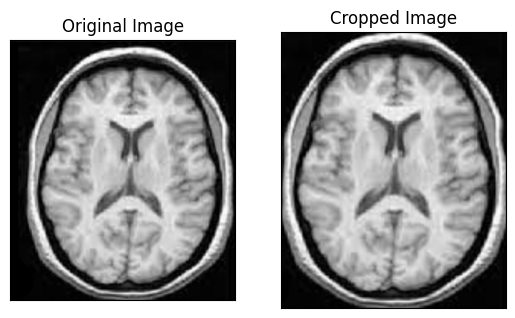

(408, 353, 3)
(396, 323, 3)


In [27]:
example_image_path = r'C:\Project_IITR\Skull_Stripping\Images\Screenshot 2023-07-07 210240.png'
example_image = cv2.imread(example_image_path)
example_new_image = crop_contour(example_image, plot=True)
print(example_image.shape)
print(example_new_image.shape)

In [5]:
import torch

# Download MiDaS dataset
midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Hybrid')
midas.to('cpu')
midas.eval()

# Download transforms pipelineṇ
transform = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = transform.dpt_transform

Using cache found in C:\Users\ASUS/.cache\torch\hub\intel-isl_MiDaS_master
C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in C:\Users\ASUS/.cache\torch\hub\intel-isl_MiDaS_master


In [28]:
# Resize image to match MiDaS model input size
resized_image = cv2.resize(example_image, (384, 384))
print(resized_image.shape)

# Normalize image
normalized_image = resized_image / 255.0

# Convert image to tensor-like format (add batch dimension)
input_tensor = np.transpose(normalized_image, (2, 0, 1))
input_tensor = np.expand_dims(input_tensor, axis=0)

# Convert input to torch tensor
input_tensor = torch.from_numpy(input_tensor).float()

# Perform depth estimation
with torch.no_grad():
    depth_prediction = midas(input_tensor)

# Convert depth prediction to numpy array
depth_map = depth_prediction.squeeze().cpu().numpy()

# Normalize depth map for visualization
depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)


# Resize image to match MiDaS model input size
resized_image2 = cv2.resize(example_new_image, (384, 384))
print(resized_image2.shape)

# Normalize image
normalized_image2 = resized_image2 / 255.0

# Convert image to tensor-like format (add batch dimension)
input_tensor2 = np.transpose(normalized_image2, (2, 0, 1))
input_tensor2 = np.expand_dims(input_tensor2, axis=0)

# Convert input to torch tensor
input_tensor2 = torch.from_numpy(input_tensor2).float()

# Perform depth estimation
with torch.no_grad():
    depth_prediction2 = midas(input_tensor2)

# Convert depth prediction to numpy array
depth_map2 = depth_prediction2.squeeze().cpu().numpy()

# Normalize depth map for visualization
depth_map2 = cv2.normalize(depth_map2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

(384, 384, 3)
(384, 384, 3)


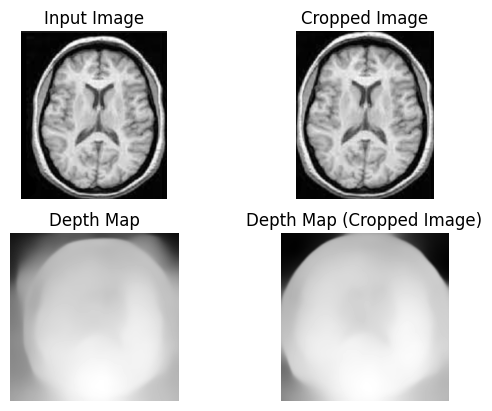

In [29]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(example_image, cmap="gray")
axs[0, 0].axis('off')
axs[0, 0].set_title('Input Image')

axs[0, 1].imshow(example_new_image, cmap="gray")
axs[0, 1].set_title('Cropped Image')
axs[0, 1].axis('off')

axs[1, 0].imshow(depth_map, cmap="gray")
axs[1, 0].axis('off')
axs[1, 0].set_title('Depth Map')

axs[1, 1].imshow(depth_map2, cmap="gray")
axs[1, 1].set_title('Depth Map (Cropped Image)')
axs[1, 1].axis('off')

plt.savefig(r"C:\Project_IITR\Binary_Classification\Results\preprocessing_depth_results\PD_Screenshot 2023-07-07 210240.png")
plt.show()